In [3]:
# Import modules for HTML display in the notebook and enable inline mode for Matplotlib
from IPython.display import display, HTML, Math, Latex
from IPython.core.magic import register_cell_magic
  
%matplotlib inline

# Import common libraries for data manipulation, optimization, and control
import pandas as pd  # type: ignore
import cvxpy as cp  # type: ignore
from matplotlib.ticker import FuncFormatter, MultipleLocator  # type: ignore
import matplotlib.pyplot as plt  # type: ignore
import numpy as np  # type: ignore
import matplotlib as mpl  # type: ignore
from matplotlib.patches import FancyArrowPatch # type: ignore
from scipy.integrate import quad # type: ignore
import importlib
import itertools
import csv
import concurrent.futures
from scipy.spatial import ConvexHull
import os, math, sys
import json
from scipy.interpolate import interp1d
import numpy as np
import json
from typing import Dict, List, Any, Optional, Literal


from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

utils_path = os.path.abspath(os.path.join("..", "Utils"))
if utils_path not in sys.path:
    sys.path.append(utils_path)

# Import utility functions from custom modules
import Tex as tex
import Graphs as gph
import Signal as sgn
import Numeric as nm

importlib.reload(tex)
importlib.reload(gph)
importlib.reload(sgn)
importlib.reload(nm)

# Attempt to configure LaTeX for text rendering, otherwise use default Matplotlib fonts
gph.use_latex()

# Set the resolution of figures generated by Matplotlib
mpl.rcParams['figure.dpi'] = 100

with open("Systems Datas.json", encoding='utf-8') as f:
    all_systems = json.load(f)

@register_cell_magic
def skip(line, cell):
  return

LaTeX has been enabled for text rendering.


∫|w(t)|dt =  0.09848227384744015


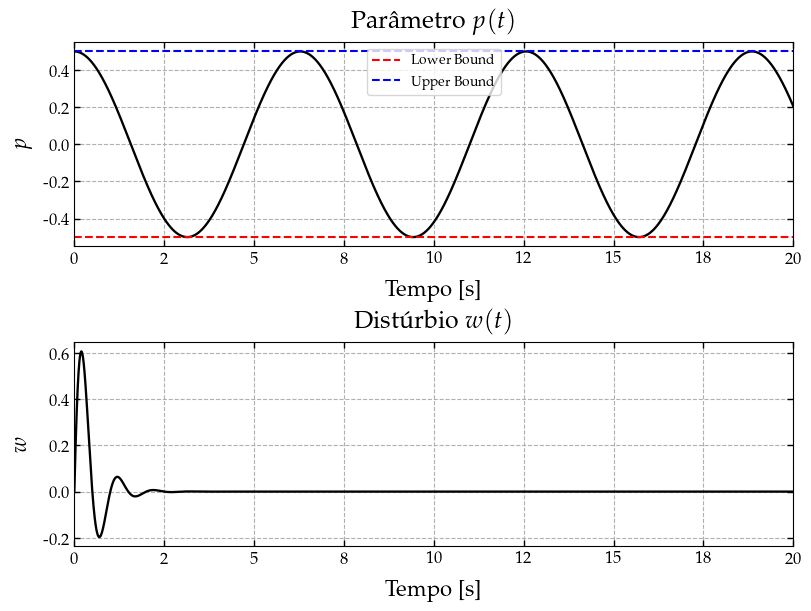

In [4]:
%matplotlib inline


simulation_step = 1e-4
simulation_time = 20
timepts = np.arange(0, simulation_time + simulation_step, simulation_step)

sys = nm.StateSpaceSystem("Systems Datas.json", "Abdullah2009",
                    simulation_time=simulation_time)
system_labels = sys.get_labels()

# === Verifica dependência de estados ===
def depends_on_states(expr: str, state_keys: list[str]) -> bool:
    return any(xi in expr for xi in state_keys)

# Extrai expressões de parâmetros e distúrbios
param_exprs = {k: v for k, v in sys.system_data.get("parameters", {}).items() if isinstance(v, str)}
dist_exprs = {k: v for k, v in sys.system_data.get("disturbances", {}).items() if isinstance(v, str)}


state_keys = system_labels.get("states", [])

param_deps = {k: depends_on_states(expr, state_keys) for k, expr in param_exprs.items()}
dist_deps = {k: depends_on_states(expr, state_keys) for k, expr in dist_exprs.items()}

# Se nenhuma expressão depende dos estados, gera os gráficos
if not any(param_deps.values()) and not any(dist_deps.values()):

  ρ_values = []
  w_values = []

  for t in timepts:
    p = sys.evaluate_parameters(t)  
    d = sys.evaluate_disturbances(t)
    ρ_values.append(p)
    w_values.append(d)


  ρ = np.array(ρ_values)
  w = np.array(w_values)

  integral_w_norm = np.sum(w**2) * (timepts[1] - timepts[0])
  print('∫|w(t)|dt = ', integral_w_norm)

  # === Gráficos ===
  cfg = {
    'style': { 'color': 'black', },
    'axis': { 'title_pad': 10, 'y_digits': 1, 'x_digits': 0,
              'x_label_fontsize': 16,
              'y_label_fontsize': 16,
              'tick_fontsize': 18,},
    'limits': { 'x_min': 0., 'x_max': simulation_time * 1e3,}
  }

  mosaic = [[key] for key in system_labels['parameters']]
  mosaic += [[key] for key in system_labels['disturbances']]

  fig = plt.figure(figsize=(8, len(mosaic) * 3), layout='constrained')
  axs = fig.subplot_mosaic(mosaic)

  t_formatted, t_unit_label, t_decimal_places = nm.format_magnitudes(
      timepts, 's', use_prefixes=True, n_divs=5
  )
  axis_limits = {'x_min': 0., 'x_max': t_formatted[-1]}

  rho_bounds = sys.system_data.get("bounds", {}).get("ρ", {})

  for idx, (section, source, values) in enumerate([
      ("parameters", system_labels['parameters'], ρ),
      ("disturbances", system_labels['disturbances'], w)
  ]):
    for i, (key, label_data) in enumerate(source.items()):
      series = [v[i] if section == "parameters" else v[0] for v in values]
      y_formatted, y_unit_label, y_decimal_places = nm.format_magnitudes(
          series, unit=label_data['unit'], use_prefixes=True, n_divs=5
      )

      ax = axs[key]

      gph.plot(
        axs[key], t_formatted, y_formatted, title=label_data['name'],
        xlabel='Tempo' + t_unit_label,
        ylabel=label_data['symbol'] + y_unit_label, label='',
        plot_cfg={**cfg,
          'axis': {**cfg['axis'],'x_digits': t_decimal_places,
                    'y_digits': y_decimal_places},
          'limits': { **cfg['limits'], **axis_limits },
        }
      )

      # Adiciona barras horizontais só para parâmetros (section == "parameters")
      if section == "parameters":
        # Os limites são obtidos pelo índice '1' do seu JSON
        bounds = rho_bounds.get(f'{i+1}', None)
        if bounds:
            ymin, ymax = bounds
            ax.axhline(y=ymin, color='red', linestyle='--', linewidth=1.5, label='Lower Bound')
            ax.axhline(y=ymax, color='blue', linestyle='--', linewidth=1.5, label='Upper Bound')

        # Adiciona legenda para as linhas de limite (opcional)
        ax.legend()
else:
    print("Parâmetros dependem dos estados — gráficos não serão gerados antes da simulação.")


In [5]:
import numpy as np


def get_C(p):
  return np.array([[0., 1.]])


def plant_dynamics(t, x, inputs, sys: nm.StateSpaceSystem):
  nu, nρ, nw = sys.nu, sys.nρ, sys.nw
  labels = sys.get_labels()

  u = inputs[0:nu].reshape(-1, 1)
  ρ = inputs[nu:nu + nρ]
  w = inputs[nu + nρ:nu + nρ + nw].reshape(-1, 1)

  state_dict = {k: float(v) for k, v in zip(
      labels.get("states", []), x.flatten())}
  param_dict = dict(zip(labels.get("parameters", []), ρ))
  disturb_dict = dict(zip(labels.get("disturbances", []), w.flatten()))

  matrices = sys.evaluate_matrices(state_dict, param_dict, disturb_dict)
  return matrices["A"] @ x + matrices["B"] @ u + matrices["E"] @ w


def plant_output(t, x, u, params):
  return x

## Simulação da Planta em Malha Aberta

In [6]:
def openloop_simulation(x0, T_s, sys: nm.StateSpaceSystem, u, timepts):
  N = len(timepts)
  nx = x0.shape[0]
  x = np.zeros((nx, N + 1, 1))
  x[:, 0, :] = x0
  y = []
  state_labels = sys.get_labels()["states"]

  for k, t in enumerate(timepts):
    state_k = x[:, k, :].flatten()
    state_dict = dict(zip(state_labels, state_k))

    ρ = sys.evaluate_parameters(t, state_dict)
    w = sys.evaluate_disturbances(t, state_dict)

    u_col = u[k].reshape(-1, 1)
    ρ_vec = np.array(sys.evaluate_parameters(t)).reshape(-1, 1)
    w_vec = np.array(sys.evaluate_disturbances(t)).reshape(-1, 1)
    inputs_vec = np.hstack((u_col, ρ_vec, w_vec))[0]

    y.append(plant_output(t, x[:, k, :], inputs_vec, ρ))

    if k < N - 1:
      x[:, k + 1, :] = nm.rk5_step(
          lambda t_, x_, inputs_, p: plant_dynamics(
              t_, x_, inputs_, sys),
          t,
          x[:, k, :],
          inputs_vec,
          T_s,
          ρ
      )

  return y

In [7]:
n_u = len(sys.get_labels()['inputs'])
u = np.zeros((len(timepts), n_u, 1))

x0 = np.array([[1.0], [-1.0]])
y = openloop_simulation(x0, simulation_step, sys, u, timepts)

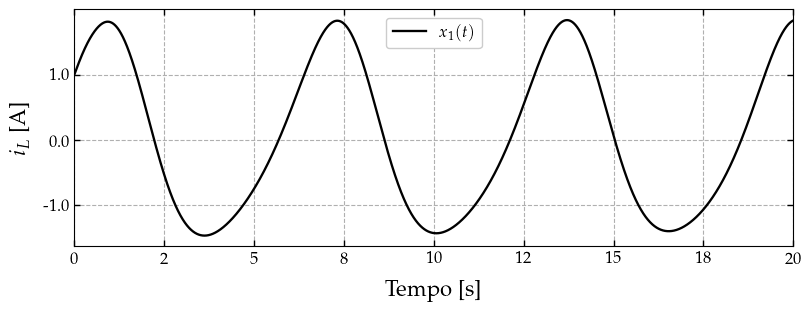

In [8]:
fig = plt.figure(figsize=(8, 3), layout='constrained')
axs = fig.subplot_mosaic([["x"]])

x_norm = np.array([np.linalg.norm(y_k) for y_k in y])

t_formatted, t_unit_label, t_decimal_places = nm.format_magnitudes(
    timepts, 's', use_prefixes=True, n_divs=5)
x1_formatted, x1_unit_label, x1_decimal_places = nm.format_magnitudes([
    v[0] for v in y], unit='A', use_prefixes=True, n_divs=5)

axis_limits = {'x_min': 0., 'x_max': t_formatted[-1]}

gph.plot(
    axs['x'], t_formatted,
    x1_formatted,
    xlabel='Tempo' + t_unit_label,
    ylabel='$i_L$' + x1_unit_label, label='$x_1(t)$',
    plot_cfg={
        **cfg,
        'axis': {**cfg['axis'], 'x_digits': t_decimal_places, 'y_digits': x1_decimal_places},
        'limits': {**cfg['limits'], **axis_limits},
    }
)

In [61]:
def solve_problem(
    h: float,
    υ: float,
    λ: Optional[float] = None,
    θ1: Optional[float] = None,
    θ2: Optional[float] = None,
    σ_bar: Optional[float] = None,
    eps: float = 1e-6
):
  n_u = sys.nu
  n_p = sys.nρ
  n_x = sys.nx

  Bnp = list(itertools.product([0, 1], repeat=n_p))
  Onx = np.zeros((n_x, n_x))

  A = {}
  B = {}

  ρ_bounds = sys.get_rho_bounds()
  u_bar = sys.get_u_bar()

  for i in Bnp:
    ρi = [ρ_bounds[idx][i[idx]] for idx in range(n_p)]
    labels = sys.get_labels()
    param_dict = dict(zip(labels.get("parameters", []), ρi))

    matrices = sys.evaluate_matrices(None, param_dict, None)

    A[i] = cp.Parameter((n_x, n_x), name=f'A', value=matrices['A'])
    B[i] = cp.Parameter((n_x, n_u), name=f'B[{i}]', value=matrices['B'])

  e = nm.get_e(5 * [n_x] + [1, n_u])

  for i in range(1, len(e)):
    e[i] = cp.Parameter(e[i].shape, value=e[i], name=f"e{i}")

  constraints = []

  Ptil = cp.Variable((n_x, n_x), PSD=True)
  Mtil = cp.Variable((2 * n_x + n_u, 2 * n_x + n_u), PSD=True)
  Q1til = cp.Variable((n_x, n_x), symmetric=True)
  Q2til = cp.Variable((n_x, n_x))
  Q3til = cp.Variable((n_x, n_u))
  Q4til = cp.Variable((n_x, n_x))
  S1til = cp.Variable((n_x, n_x), symmetric=True)
  S2til = cp.Variable((n_x, n_x))
  S3til = cp.Variable((n_x, n_u))
  S4til = cp.Variable((n_x, n_x))

  Ktil = cp.Variable((n_u, n_x), name=f'K')
  L1til = cp.Variable((n_u, n_x), name=f'L1')
  L2til = cp.Variable((n_u, n_x), name=f'L2')
  ℵ = cp.Variable((n_u, n_u), diag=True)
  constraints += [ℵ >> eps * np.eye(ℵ.shape[0])]

  Rtil = cp.Variable((n_x, n_x), PSD=True)
  Ξtil = cp.Variable((n_x, n_x), PSD=True)
  λ = cp.Parameter(value=λ, name='λ')
  β = cp.Variable(pos=True)
  θ1 = cp.Parameter(value=θ1, name='θ1')
  θ2 = cp.Parameter(value=θ2, name='θ2')
  σ_bar = cp.Parameter(value=σ_bar, name='σ_bar')

  X = cp.Variable((n_x, n_x))
  Ytil = cp.Variable((2 * n_x, e[1].shape[1]))

  Rcal = cp.bmat([[Rtil, Onx],
                  [Onx, 3. * Rtil]])

  Fscr = e[1].T + υ * e[2].T + υ * e[4].T

  κ1 = cp.bmat([[e[2]], [e[7]], [e[5]]])
  κ2 = cp.bmat([[e[1] - e[2]],
                [e[1] + e[2] - 2. * e[3]]])

  def get_Λ(i):
    Bscr = A[i] @ X @ e[1] + B[i] @ Ktil @ e[2] - \
        X @ e[4] + B[i] @ Ktil @ e[5] - B[i] @ ℵ @ e[7]

    Θ1 = (e[1] - e[2]).T @ S1til @ (e[1] - e[2]) + \
        nm.He((e[1] - e[2]).T @ (S2til @ e[2] + S3til @ e[7] + S4til @ e[5]))

    Θ2 = nm.He(e[3].T @ (Q2til @ e[2] + Q3til @ e[7] + Q4til @ e[5]))

    Θ3 = nm.He(e[1].T @ (Q1til @ e[3] + Q2til @ e[2] +
                         Q3til @ e[7] + Q4til @ e[5]))

    Θ4 = nm.He(e[4].T @ (S1til @ (e[1] - e[2]) + S2til @
               e[2] + S3til @ e[7] + S4til @ e[5])) + \
        e[4].T @ Rtil @ e[4]

    Θ5 = e[7].T @ (ℵ @ e[7] - L1til @ e[2] - L2til @ e[5])

    Θtil = {}
    Θtil['0'] = -λ * e[6].T @ e[6] - (1 + σ_bar * θ2) * e[5].T @ Ξtil @ e[5] - \
        Θ1 - h * e[3].T @ Q1til @ e[3] + h * Θ3 + h * κ1.T @ Mtil @ κ1 + \
        h * e[4].T @ Rtil @ e[4] + θ2 * e[2].T @ Ξtil @ e[2] - \
        Θ5 + nm.He(e[1].T @ Ptil @ e[4] + Fscr @ Bscr - κ2.T @ Ytil) + h * Θ4

    Θtil['h'] = -λ * e[6].T @ e[6] - (1 + σ_bar * θ2) * e[5].T @ Ξtil @ e[5] - \
        Θ1 - h * Θ2 - h * e[3].T @ Q1til @ e[3] - h * κ1.T @ Mtil @ κ1 - Θ5 + \
        nm.He(e[1].T @ Ptil @ e[4] + Fscr @ Bscr -
              κ2.T @ Ytil) + θ2 * e[2].T @ Ξtil @ e[2]

    Γ1 = Θtil['0']

    Γ2_11 = Θtil['h']
    Γ2_12 = Ytil.T

    Γ2_21 = Γ2_12.T
    Γ2_22 = - (1. / h) * Rcal

    Γ2 = cp.bmat([[Γ2_11, Γ2_12],
                  [Γ2_21, Γ2_22]])

    return Γ1, Γ2

  # binary_pairs = nm.binary_pairs(n_p)

  # for pairs in binary_pairs:
  #   LMI_SUM = {}
  #   LMI_SUM['0'], LMI_SUM['h'] = 0., 0.

  #   for pair in pairs:
  #     Λ = {}
  #     Λ['0'], Λ['h'] = get_Λ(pair[0], pair[1])
  #     LMI_SUM['0'] += Λ['0']
  #     LMI_SUM['h'] += Λ['h']

  #   constraints += [LMI_SUM['0'] << -eps * np.eye(LMI_SUM['0'].shape[0])]
  #   constraints += [LMI_SUM['h'] << -eps * np.eye(LMI_SUM['h'].shape[0])]

  for i in Bnp:
    Λ1, Λ2 = get_Λ(i)
    constraints += [Λ1 << -eps * np.eye(Λ1.shape[0])]
    constraints += [Λ2 << -eps * np.eye(Λ2.shape[0])]

  for ell in range(n_u):
    # for j in Bnp:
    LMISAT11 = Ptil - Ξtil
    LMISAT12 = np.zeros((n_x, n_x))
    LMISAT13 = np.zeros((n_x, 1))
    LMISAT14 = (Ktil[ell:ell+1] - L1til[ell:ell+1]).T

    LMISAT21 = LMISAT12.T
    LMISAT22 = (1.0 / σ_bar) * Ξtil
    LMISAT23 = np.zeros((n_x, 1))
    LMISAT24 = (Ktil[ell:ell+1] - L2til[ell:ell+1]).T

    LMISAT31 = LMISAT13.T
    LMISAT32 = LMISAT23.T
    LMISAT33 = (1. - (1. / (σ_bar * θ1))) * np.eye(1)
    LMISAT34 = np.zeros((1, 1))

    LMISAT41 = LMISAT14.T
    LMISAT42 = LMISAT24.T
    LMISAT43 = LMISAT34.T
    LMISAT44 = (u_bar[ell] ** 2) * np.eye(1)

    LMISAT = cp.bmat(
        [[LMISAT11, LMISAT12, LMISAT13, LMISAT14],
         [LMISAT21, LMISAT22, LMISAT23, LMISAT24],
         [LMISAT31, LMISAT32, LMISAT33, LMISAT34],
         [LMISAT41, LMISAT42, LMISAT43, LMISAT44]])

    constraints += [LMISAT >> 0]

  LMID0_11 = β * np.eye(n_x)
  LMID0_12 = np.eye(n_x)
  LMID0_21 = np.eye(n_x)
  LMID0_22 = X + X.T - Ptil

  LMID0 = cp.bmat([[LMID0_11, LMID0_12],
                   [LMID0_21, LMID0_22]])

  constraints += [LMID0 >> 0]

  constraints += [Ξtil >> eps * np.eye(n_x)]

  obj = cp.Minimize(β)
  prob = cp.Problem(obj, constraints)

  # Solve the problem using the MOSEK solver
  # prob.solve(solver=cp.MOSEK, verbose=False, ignore_dpp=True)
  prob.solve(solver=cp.MOSEK, verbose=False, ignore_dpp=True)

  # Initialize variables to store results
  design_results = None

  # Display the results
  if prob.status not in ["infeasible", "unbounded"]:
    Xinv = np.linalg.inv(X.value)
    Ξ = Xinv.T @ Ξtil.value @ Xinv
    P = Xinv.T @ Ptil.value @ Xinv
    S2 = Xinv.T @ S2til.value @ Xinv

    error = False

    if error == False:
      K = Ktil.value @ Xinv
      L1 = L1til.value @ Xinv
      L2 = L2til.value @ Xinv

      etm_results = {'Ξ': Ξ}
      design_results = {
          'optimal_value': prob.value,
          'etm': etm_results,
          'controller': {'K': K, 'L1': L1, 'L2': L2},
          'lyapunov': [P, S2],
          'bounds': [β.value]
      }
  else:
    # print('The problem is not feasible')
    design_results = None

  return design_results

In [64]:
# Definição inicial das variáveis
Ξ = Ψ = K = L1 = P = γ = β = None
θ1, Θ2, λ = None, None, None
σ_bar = 95

# Parâmetros e resolução do problema
h, υ, θ2, λ = 1e-3, 1e-1, 1.0, 1e-1
θ1 = (1. / λ) * (np.exp(λ * h) - 1) + 1
prob_res = solve_problem(h=h, υ=υ, λ=λ, θ1=θ1, θ2=θ2, σ_bar=σ_bar, eps=1e-6)

if prob_res is not None:
  Ξ = prob_res['etm']['Ξ']
  K, L1, L2 = prob_res['controller']['K'], prob_res['controller']['L1'], \
      prob_res['controller']['L2']
  P, S2 = prob_res['lyapunov']
  β = prob_res['bounds']

  display(Math(rf'\Xi = {tex.mat2tex(Ξ)}'))
  display(Math(rf'P = {tex.mat2tex(P)}'))

  display(Math(rf'K = {tex.mat2tex(K)}'))
  display(Math(rf'L1 = {tex.mat2tex(L1)}'))
else:
  print('Problema não é factível!')

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

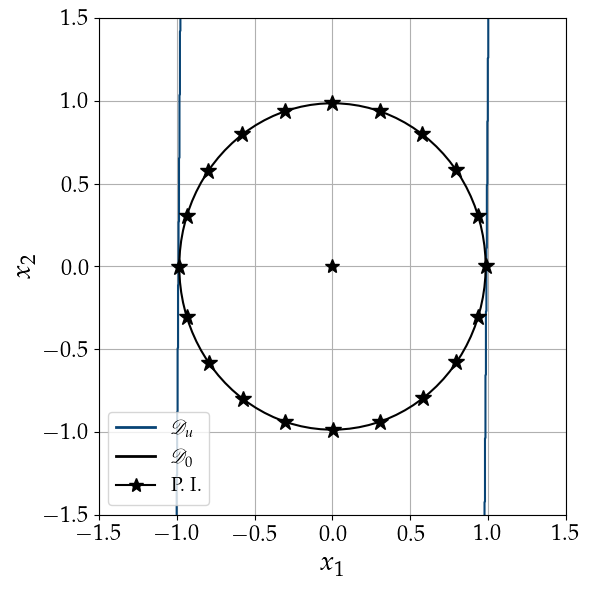

In [ ]:
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize=(6., 6.))

# Intervalo de plotagem
x1_range = (-1.5, 1.5)
x2_range = (-1.5, 1.5)
num_points = 20

u_bar = sys.get_u_bar()

# Malha de pontos
x_vals = np.linspace(x1_range[0], x1_range[1], int(1e3))
y_vals = np.linspace(x2_range[0], x2_range[1], int(1e3))

X, Y = np.meshgrid(x_vals, y_vals)
points = np.vstack([X.ravel(), Y.ravel()]).T

# Região de saturação (única, já que K e L1 são constantes)
result = np.abs(points @ (K - L1).T)
Du_region = (result.reshape(X.shape) <= u_bar[0])

# Contorno da região admissível de controle
ax.contour(X, Y, Du_region, colors='#084475', linewidths=1.5)

# Pontos do elipsoide unitário (condição inicial)
X0_list = nm.ellipsoid_boundary_points(P, 1, num_points)
plt.plot(X0_list[0], X0_list[1], '*',
         linestyle='None', c='black', markersize=12)

# Inclui um ponto inicial específico
X0_list = np.hstack((np.array([[-0.20346692], [0.33822176]]), X0_list))

# Elipsoide D0
D0 = nm.get_ellipsoid_boundary(P, 1)
plt.plot(D0['x1_vals'], D0['x2_vals'],
         'k-', label=r'$\mathscr{D}_0$')

# Como não existe mais região com δ e γ, removemos o Dx

# Ajustes finais de layout
ax.set_xlabel("$x_1$", fontsize=20)
ax.set_ylabel("$x_2$", fontsize=20)
ax.tick_params(axis='both', labelsize=16)
ax.grid(True)

# Legenda customizada (ajustada para não incluir Dx)
elements = [
    ('line', {'color': '#084475', 'linestyle': '-', 'linewidth': 2.0}),
    ('line', {'color': 'black', 'linestyle': '-', 'linewidth': 2.}),
    ('marker', {'marker': '*', 'color': 'black', 'markersize': 10})
]

labels = [r'$\mathscr{D}_u$', r'$\mathscr{D}_0$', 'P. I.']

gph.create_custom_legend(ax, elements, labels)

plt.tight_layout()
plt.show()

In [118]:
w = np.zeros((len(timepts), sys.nw, 1))


def closedloop_simulation(x0, η0, σ0, T_s):

  N = len(timepts)
  nx = x0.shape[0]

  x = np.zeros((nx, N + 1, 1))
  η = np.zeros((N + 1, 1))

  x[:, 0, :] = x0
  η[0, :] = η0

  σ = np.full((N + 1, 1), 0., dtype=np.float64)
  σ[0, :] = np.float64(σ0)

  xτ = x0.copy()

  y = []
  uc = []

  ρ_hat = np.array(sys.evaluate_parameters(0)).reshape(-1, 1)
  x_hat = x0
  event_times = [0.]

  next_time_sampling = h

  def triggering_condition(_σ, _xτ, _ε, _η):
    Γ = _σ * (_xτ.T @ Ξ @ _xτ) - (_ε.T @ Ξ @ _ε)
    return (_η + θ1 * Γ) < -1e-7

  def sigma_dynamics(t, _σ, _η, params):
    _ε = x_hat - xτ
    σ_dot = (θ2 / _σ) * (((1. / _σ) - σ_bar) * _ε.T @ Ξ @ _ε -
                         (1. / (θ1 * _σ)) * _η) - xτ.T @ Ξ @ xτ
    return σ_dot

  def etm_dynamics(t, _η, _σ, params):
    ε = x_hat - xτ
    Γ = _σ * (xτ.T @ Ξ @ xτ) - (ε.T @ Ξ @ ε)
    η_dot = - λ * _η + Γ[0][0]
    return η_dot

  def control_signal():
    u_bar = sys.get_u_bar()
    uc_k = K @ x_hat
    return np.array([[sgn.sat(uc_k[0, 0], u_bar[0])]])

  for k, t in enumerate(timepts):
    ρ = np.array(sys.evaluate_parameters(t)).reshape(-1, 1)
    w = np.array(sys.evaluate_disturbances(t)).reshape(-1, 1)
    w = np.zeros((sys.nw, 1))

    # Verificação da condição de acionamento
    if t >= next_time_sampling:
      next_time_sampling += h
      xτ = x[:, k, :]
      ε = x_hat - xτ
      new_event = triggering_condition(σ[k, :], xτ, ε, η[k, :])
      if new_event:
        # print('True')
        ρ_hat = ρ
        x_hat = xτ
        event_times.append(t)

    # Cálculo do sinal de controle
    u_sat = control_signal()
    inputs_vec = np.hstack((u_sat, ρ, w))[0]

    # Saída da planta
    y.append(plant_output(t, x[:, k, :], inputs_vec, ρ))

    # Atualização dos estados para o próximo passo (k+1)
    if k < N:
      x[:, k + 1, :] = nm.rk5_step(
          lambda t_, x_, inputs_, p: plant_dynamics(t_, x_, inputs_, sys),
          t, x[:, k, :], inputs_vec, T_s, ρ)

      σ_next = nm.rk5_step(sigma_dynamics, t, σ[k, :], η[k, :], T_s, None)
      # print(σ_next)
      σ[k + 1, :] = np.maximum(σ_next, 1e-6)

      η[k + 1, :] = nm.rk5_step(etm_dynamics, t, η[k, :], σ[k, :], T_s, None)

    # Armazena controle e saída em k
    uc.append(u_sat)
  return y, uc, σ[:N], η[:N], event_times

In [119]:
import os
import json
import numpy as np
from concurrent.futures import ThreadPoolExecutor

# -----------------------------
# Funções auxiliares
# -----------------------------


def convert_to_serializable(obj):
  if isinstance(obj, np.ndarray):
    return obj.tolist()
  elif isinstance(obj, list):
    return [convert_to_serializable(item) for item in obj]
  elif isinstance(obj, dict):
    return {key: convert_to_serializable(val) for key, val in obj.items()}
  return obj


def convert_to_numpy(obj):
  return {
      'trajectories': [np.array(y_k) for y_k in obj['trajectories']],
      'control-signal': [np.array(u_k) for u_k in obj['control-signal']],
      'sigma': [np.array(sigma_k) for sigma_k in obj['sigma']],
      'eta': [np.array(eta_k) for eta_k in obj['eta']],
      'inter-event-times': obj['inter-event-times'],
  }

# -----------------------------
# Função de simulação
# -----------------------------


def get_trajectories(i):
  x0 = np.array([[X0_list[0][i]], [X0_list[1][i]]])
  η0 = np.array([[0.]])
  σ0 = 0.01

  # closedloop_simulation precisa estar definido globalmente
  y, uc, σ, η, event_times = closedloop_simulation(
      x0, η0, σ0, T_s=simulation_step
  )
  inter_event_times = np.diff(event_times).tolist()

  return {
      'trajectories': y,
      'sigma': σ,
      'eta': η,
      'control-signal': uc,
      'inter-event-times': inter_event_times
  }


# -----------------------------
# Configurações
# -----------------------------
experiment_name = "Results/Notebook-05/ClosedLoop_Results.json"
force_simulation = True
simulations_amount = 1

results_clsim = {
    'inter-event-times': [],
    'control-signal': [],
    'trajectories': [],
    'sigma': [],
    'eta': [],
}

# -----------------------------
# Carregar ou simular
# -----------------------------
if os.path.exists(experiment_name) and not force_simulation:
  print(f"O arquivo {experiment_name} já existe. Carregando dados salvos.")
  with open(experiment_name, "r") as f:
    loaded = json.load(f)
    results_clsim = convert_to_numpy(loaded)
else:
  print("Executando simulações...")

  # ThreadPoolExecutor funciona de forma segura em notebooks
  with ThreadPoolExecutor() as executor:
    results = list(executor.map(
        get_trajectories, range(simulations_amount)))

  # Atualizar estrutura de resultados
  for res in results:
    results_clsim['trajectories'].append(res['trajectories'])
    results_clsim['inter-event-times'].append(res['inter-event-times'])
    results_clsim['control-signal'].append(res['control-signal'])
    results_clsim['sigma'].append(res['sigma'])
    results_clsim['eta'].append(res['eta'])

  # Salvar resultados
  results_serializable = convert_to_serializable(results_clsim)
  os.makedirs(os.path.dirname(experiment_name), exist_ok=True)
  with open(experiment_name, "w") as f:
    json.dump(results_serializable, f, indent=2)

  print(f"Simulações concluídas. Resultados salvos em {experiment_name}.")

Executando simulações...
Simulações concluídas. Resultados salvos em Results/Notebook-05/ClosedLoop_Results.json.


Estado Inicial:  [ 6.79354732e-04 -9.85089968e-01]
Número de Eventos Acionados:  40
Menor IET Obtido:  0.003999999999999998
Máximo IET Obtido:  4.053100000000001
Média do Intervalos de Tempo entre Eventos:  0.36112500000000003


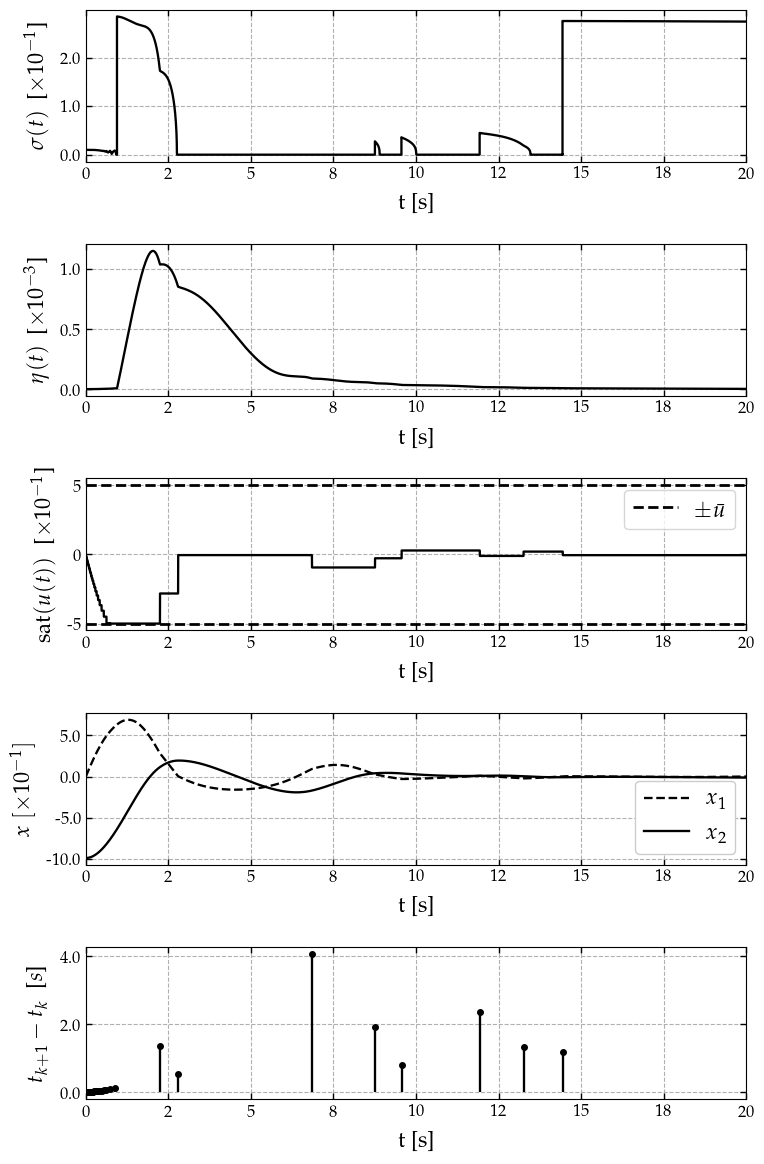

In [120]:
%matplotlib inline

simulation_index = 0
inter_event_times = results_clsim['inter-event-times'][simulation_index]
uc = results_clsim['control-signal'][simulation_index]
y = results_clsim['trajectories'][simulation_index]
_σ = results_clsim['sigma'][simulation_index]
η = results_clsim['eta'][simulation_index]
event_times = np.cumsum(inter_event_times)

mosaic = [['σ'], ['η'], ['sat'], ['x'], ['iet']]    
fig, axs = plt.subplot_mosaic(mosaic, figsize=(8, 12))

t_formatted, t_unit_label, t_decimal_places = nm.format_magnitudes(
    timepts, 's', use_prefixes=True, n_divs=5)

axis_limits = {'x_min': 0., 'x_max': 20}

print("Estado Inicial: ", y[0].reshape(-1))
print("Número de Eventos Acionados: ", len(inter_event_times))
print("Menor IET Obtido: ", min(inter_event_times))
print("Máximo IET Obtido: ", max(inter_event_times))
print("Média do Intervalos de Tempo entre Eventos: ", np.mean(
      inter_event_times) )


σ_f, σ_ul, σ_dp = nm.format_magnitudes(
    _σ, '', use_prefixes=False, n_divs=5)

gph.plot(
    axs['σ'], t_formatted, σ_f,
    xlabel='t [s]', ylabel='$\\sigma(t)\\,$' + σ_ul,
    title='',
    plot_cfg={**cfg,
        'axis': {**cfg['axis'],'x_digits': t_decimal_places,
                  'y_digits': σ_dp},
        'limits': { **cfg['limits'], **axis_limits },
      })

n_f, n_ul, n_dp = nm.format_magnitudes(
    η, '', use_prefixes=False, n_divs=5)

gph.plot(
    axs['η'], t_formatted, n_f,
    xlabel='t [s]', ylabel='$\\eta(t)\\,$' + n_ul,
    # title='Variável dinâmica do ETM',
    plot_cfg={**cfg,
        'axis': {**cfg['axis'],'x_digits': t_decimal_places,
                  'y_digits': n_dp},
        'limits': { **cfg['limits'], **axis_limits },
      })

# # Cria o inset axis (janela de zoom)
# axins = inset_axes(axs['σ'], width="40%", height="50%", 
#                    loc='lower right', borderpad=3)

# for spine in axins.spines.values():
#     spine.set_edgecolor("#084475")   # cor da borda
#     spine.set_linewidth(1.2)       # espessura da borda

# # Plota no inset a mesma curva
# axins.plot(t_formatted, σ_f, color='black')

# Define os limites do zoom
# x1, x2 = 0, 0.5      # intervalo em t (s)
# y1, y2 = 1, 1.055  # intervalo em σ(t)
# axins.set_xlim(x1, x2)
# axins.set_ylim(y1, y2)
# axins.grid()

# # Remove ticks em excesso no zoom
# axins.tick_params(axis='both', which='both', labelsize=12)

# # Liga visualmente o zoom ao gráfico principal
# mark_inset(axs['σ'], axins, loc1=2, loc2=3, fc="none", ec="#084475")


axs['sat'].hlines([u_bar[0] * 1e1, -u_bar[0] * 1e1], 
                  0, t_formatted[-1], colors='black', linestyles='--', label='$\\pm \\bar u$', linewidths=2.)
axs['sat'].legend(prop={'size': 16})


# Plot sinal de saída
gph.plot(
    axs['x'], t_formatted, [v[0] * 1e1 for v in y],
    xlabel='t [s]', label='$x_1$', plot_cfg={**cfg,
        'style': {**cfg['style'], 'linestyle': '--'},})

gph.plot(
    axs['x'], t_formatted, [v[1] * 1e1 for v in y],
    xlabel='t [s]', ylabel=r'$x$ $[\times 10^{-1}]$',
    # title='Estados da Planta - $x(t)$', 
    label='$x_2$',
    plot_cfg={**cfg,
        'axis': {**cfg['axis'],'x_digits': t_decimal_places,
                  'y_digits': 1},
        'limits': { **cfg['limits'], **axis_limits },
        'legend': {'fontsize': 16}
      })

gph.plot(
    axs['sat'], t_formatted,
    [float(v[0, 0]) * 1e1 for v in uc],
    xlabel='t [s]', ylabel='sat$(u(t))\\;$ [$\\times 10^{-1}$]',
    # title='Sinal de Controle Saturado (sat($u(t)$))', 
    plot_cfg={**cfg,
        'axis': {**cfg['axis'],'x_digits': t_decimal_places,
                  'y_digits': 0},
        'limits': { **cfg['limits'], **axis_limits },
        'legend': {'fontsize': 16}
      })

# Plot dos IETs
if len(inter_event_times) > 0:
    stem_cfg = cfg.copy()
    stem_cfg['axis']['y_digits'] = 0

    gph.stem(
      axs['iet'], [et for et in event_times],
      [et for et in inter_event_times],
      xlabel='t [s]', ylabel='$t_{k+1} - t_k\\;$ [$s$]',
      # title='Intervalos entre Eventos',
      stem_cfg={**cfg,
        'axis': {**cfg['axis'],'x_digits': t_decimal_places,
                  'y_digits': 1},
        'limits': { **cfg['limits'], **axis_limits },
      })


else:
    axs['iet'].text(0.5, 0.5, 'No triggered events',
                    ha='center', va='center', fontsize=14,
                    transform=axs['iet'].transAxes)
    axs['iet'].set_title('Inter-event Times')
    axs['iet'].set_xlabel('t [s]')
    axs['iet'].set_ylabel('$t_{k+1} - t_k$ [$ms$]')
    axs['iet'].set_xlim([0, simulation_time])
    axs['iet'].set_ylim([0, 1])  # valor simbólico
    axs['iet'].grid(False)

plt.tight_layout(pad=2.)

IndexError: index 1 is out of bounds for axis 0 with size 1

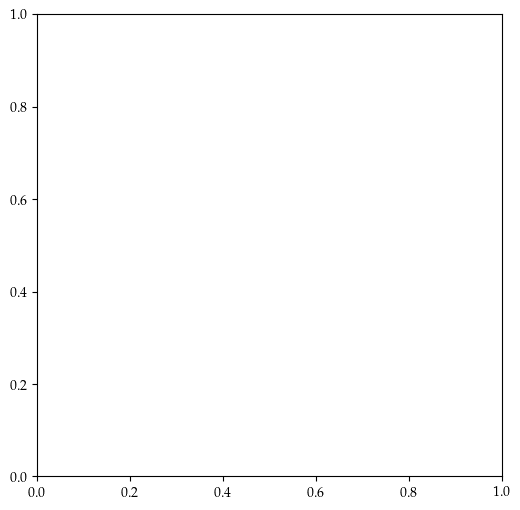

In [121]:
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize=(6., 6.))

# Definindo intervalo de plotagem
x1_range = (-.5, .5)
x2_range = (-.5, .5)
num_points = 21

# a_q = nm.get_vertices(x_bounds)

B2 = nm.binary_set(sys.nρ)
u_bar = sys.get_u_bar()

X, Y = np.meshgrid(x_vals, y_vals)
points = np.vstack([X.ravel(), Y.ravel()]).T

x_vals = np.linspace(x1_range[0], x1_range[1], int(1e3))
y_vals = np.linspace(x2_range[0], x2_range[1], int(1e3))

# Du_tilde_region = np.ones(X.shape, dtype=bool)
# for b in B2:
#     result = np.abs(points @ (K[b]).T)
#     Du_tilde_region &= (result.reshape(X.shape) <= u_bar[0])
# ax.contourf(X, Y, Du_tilde_region, levels=[0.4, 1.5], colors=['#f2f2f2'], linewidths=0)

Du_tilde_region = np.ones(X.shape, dtype=bool)
for b in B2:
    result = np.abs(points @ (K[b]).T)
    Du_tilde_region &= (result.reshape(X.shape) <= u_bar[0])
saturation_region = ~Du_tilde_region

ax.contourf(X, Y, saturation_region, levels=[0.4, 1.5], colors=['#e4e4e4'], linewidths=0)



Du_region = np.ones(X.shape, dtype=bool)
for b in B2:
  result = np.abs(points @ (K[b] - L1[b]).T)
  # result = np.abs(points @ (K[b]).T)
  Du_region &= (result.reshape(X.shape) <= u_bar[0])
ax.contour(X, Y, Du_region, colors='#084475', linewidths=1.5)

X0_list = nm.ellipsoid_boundary_points(P, 1, num_points)
plt.plot(X0_list[0], X0_list[1], '*',
         linestyle='None', c='black', markersize=12)

D0 = nm.get_ellipsoid_boundary(P, 1)
plt.plot(D0['x1_vals'], D0['x2_vals'], 
         'k-', label='')

μ_inv = 1. + (1. / (γ * δ))
Dx = nm.get_ellipsoid_boundary(P, μ_inv)
plt.plot(Dx['x1_vals'], Dx['x2_vals'], 
         'k--', label='')

# Apresentação das trajetórias dos estados 
trajectories = results_clsim['trajectories']
for y in trajectories:
  ax.plot([v[0] for v in y], [v[1] for v in y], 
          color='black', linestyle=':')


# Ajustes finais de layout
ax.set_xlabel("$x_1$", fontsize=20)
ax.set_ylabel("$x_2$", fontsize=20)
ax.tick_params(axis='both', labelsize=16)

ax.grid(True)

# Legendas
elements = [
    ('line', {'color': '#084475', 'linestyle': '-', 'linewidth': 2.0}),
    ('line', {'color': 'black', 'linestyle': '--', 'linewidth': 2.}),
    ('line', {'color': 'black', 'linestyle': '-', 'linewidth': 2.}),
    ('line', {'color': 'black', 'linestyle': ':', 'linewidth': 2.}),
    # ('marker', {'marker': '*', 'color': 'black', 'markersize': 10})
]

labels = [r'$\mathscr{D}_u$', r'$\mathscr{D}_x$', r'$\mathscr{D}_0$', 
          'Trajetórias']
gph.create_custom_legend(ax, elements, labels)

# Exibir o gráfico
plt.tight_layout()